# Building our own Face Detection model

This model comes along my "FaceID project". It's the first part of this project which should classify if a photo contains a face or no. 

It's a binary classification and uses the bases of a ResNet50 model (pretrained on [ImageNet](https://image-net.org/)) and then, fine tuned with faces drawn from the [LFW database](http://vis-www.cs.umass.edu/lfw/) and backgrounds drawn from [House Rooms dataset](https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset). 

This model is known as a *face detection* model (opposed to a *face recognition* model which will see in detail in the next part). It classifies whether there is a face (a person) or not in a image. The output of the model is binary (0 or 1) where 0 means there is no face and 1 there is a face.

# Import

In [1]:
import os

import numpy as np
import glob
import pickle
import tqdm
import random as rd
import time

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

%pip install torchinfo
from torchinfo import summary

from PIL import Image

import scipy as sp
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


# Creating dataset class

The **FaceDetection_dataset** class is used to create a Pytorch instance of the dataset. It should handle several things :
*   Returns training and validation dataset
*   Returns Pytorch Tensors
*   Augments the dataset
*   Normalizes the dataset

I chose to augment the dataset with random horizontal flips and random rotations to simulate subject's positionning imperfections.

Also, as suggests the [ResNet paper](https://arxiv.org/abs/1512.03385), and as recalls the [Pytorch websibe](https://pytorch.org/hub/pytorch_vision_resnet/) : when using pretrained ResNet, image pixel values should be between `[0,1]` and one should normalize the images using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

In [2]:
class FaceDetection_dataset(Dataset):
    def __init__(self, imgset_face:list, imgset_noface:list, split:str, isValSet_bool:bool=False, 
                 isAugment_bool:bool=False, isNormalize_bool:bool=True):
        """
        Class that build the dataset to feed the Pytorch Dataloader 

        -------------------
        Class attributs:
            imgset_face: list of PIL images
                The list of PIL images with face in it
            imgset_face: list of PIL images.
                The list of PIL images without face in it (typically random
                background found in the 'houseroom dataset').
            split: str
                Used to select training set or validation set
            isValSet_bool: bool
                Boolean to construct a validation dataset
            isAugment_bool: bool
                Boolean to activate the data augmentation preprocessing
            isNormalize_bool: bool
                Boolean to activate normalization of each channel by mean and 
                std ResNet paper values.
        """
        
        self.isAugment_bool = isAugment_bool
        self.isNormalize_bool = isNormalize_bool

        split_pct = float(split.strip('%'))/100
        len_imageset_face = round(len(imgset_face) * split_pct)
        len_imageset_noface = round(len(imgset_noface) * split_pct)

        

        if isValSet_bool == False:
            imgset_face = imgset_face[:len_imageset_face] 
            imgset_noface = imgset_noface[:len_imageset_noface]
        else :
            imgset_face = imgset_face[-len_imageset_face:]
            imgset_noface = imgset_noface[-len_imageset_noface:]
        
        self.imgset = imgset_face + imgset_noface

        label_face = np.ones(len(imgset_face)).tolist()
        label_noface = np.zeros(len(imgset_noface)).tolist()
        self.labelset = label_face + label_noface
        

    def preprocess(self, img)->torch.Tensor:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((256, 256)), 
            torchvision.transforms.ToTensor()])
        img_t = transform(img)
        
        if self.isAugment_bool:
            augment = torchvision.transforms.Compose([
                torchvision.transforms.CenterCrop((224,224)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.RandomRotation(degrees=(-10,10))])
            img_t = augment(img_t)

        if self.isNormalize_bool:
            normalize = torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
            img_t = normalize(img_t)
        return img_t

    def __len__(self):
        return len(self.imgset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.imgset[idx]
        image_t = self.preprocess(image)
        
        label = self.labelset[idx]
            
        return image_t, torch.tensor(label).to(torch.float32)


# Loading data
To improve data streamflow, datasets are already converted to `PIL.Image` and stored in a `.pkl` file such as : 
* `lfw_PIL.pkl` contains 3000 random images drawn from LFW database and converted into `PIL.Image`
* `houseroom_3000_PIL.pkl` contains 3000 random images drawn from House Rooms Kaggle dataset and converted into `PIL.Image`.

### Working on the CLOUD

In [ ]:
### https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset
### http://vis-www.cs.umass.edu/lfw/

data_path = '/content/drive/MyDrive/Colab Notebooks'

#----------------------------- Loading images with a face ---------------------#
#imgset_face_path = glob.glob(data_path + '/face_verification/*dataset/*lfw/*/*')
#imgset_face_PIL = [Image.open(k).convert('RGB') for k in imgset_face_path]
with open(data_path + '/face_verification/dataset/dataset_augmented/lfw_PIL.pkl', 'rb') as lfw_PIL:
    imgset_face_PIL = pickle.load(lfw_PIL)


#----------------------------- Loading images without face --------------------#
#imgset_noface_path = glob.glob(data_path + '/face_verification/*dataset/*houseroom/*/*')
#imgset_noface_PIL = [Image.open(k).convert('RGB') for k in imgset_noface_path]
with open(data_path + '/face_verification/dataset/houseroom/houseroom_3000_PIL.pkl', 'rb') as houseroom_PIL:
    imgset_noface_PIL = pickle.load(houseroom_PIL)### https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset
### http://vis-www.cs.umass.edu/lfw/

### Working on LOCAL MACHINE

In [3]:
data_path = '/Users/thierryksstentini/Downloads/dataset'

#----------------------------- Loading images with a face ---------------------#
with open("/Users/thierryksstentini/Downloads/dataset/dataset_augmented/lfw_PIL.pkl", 'rb') as lfw_PIL:
    imgset_face_PIL = pickle.load(lfw_PIL)


#----------------------------- Loading images without face --------------------#
with open("/Users/thierryksstentini/Downloads/dataset/houseroom_3000_PIL.pkl", 'rb') as houseroom_PIL:
    imgset_noface_PIL = pickle.load(houseroom_PIL)

# Creating datasets and dataloaders


In [4]:
#----------------------------- Creating datasets ------------------------------#
dataset_train = FaceDetection_dataset(imgset_face_PIL, imgset_noface_PIL, split='80%', isValSet_bool=False, isAugment_bool=True)
dataset_val = FaceDetection_dataset(imgset_face_PIL, imgset_noface_PIL, split='20%', isValSet_bool=True)

del imgset_face_PIL, imgset_noface_PIL

#----------------------------- Creating loaders -------------------------------#
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

# Creating the model
Here I use a pretrained ResNet50 model from torchvision models. All the layers are frozen (`param.requires_grad = False`) and the last layer is turned into a linear layer (`torch.nn.Linear`) with a unique output unit (since it is a binary classification, only one output is need). 

Finally, we applied a sigmoid function to the forward output to turn the output into probability. 

In [6]:
class resNet50_custom(torch.nn.Module):
    def __init__(self):
        super(resNet50_custom, self).__init__()
        self.res50 = torchvision.models.resnet50(pretrained = True, progress = True)
        for param in self.res50.parameters():
            param.requires_grad = False
        self.res50.fc = torch.nn.Linear(2048, 1)

    def forward(self, input):
        output = self.res50(input)
        return torch.sigmoid(output)


# Model compilation
For a binary classification like this one, we use the `nn.BCELoss` loss function which measures the Binary Cross Entropy between the target and the input probabilities. 

`optim.Adam` optimization with `lr=0.001` are also used. It is usually a good starting point before trying anything else.

Finally, we'll see the loss is decreasing pretty fast so 2 epochs are enough.

In [6]:
resNet50_model = resNet50_custom()
BCEloss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(resNet50_model.parameters(), lr=0.001)
num_epochs = 2
#summary(resNet50_model, (32, 3, 224, 224));

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
### Choosing device between CPU or GPU

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('mps') if torch.has_mps else torch.device('cpu')

print("\n------------------------------------")
print(f"Execute notebook on - {device} -")
print("------------------------------------\n")


------------------------------------
Execute notebook on - mps -
------------------------------------



# Building the training loop

# Training

In [ ]:
resNet50_model.to(device)
train_loss_list = []
valid_loss_list = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} on {device} \n-------------------------------")
    resNet50_model.train()
    train_loss = 0.0
    size_trainset = len(train_dataloader.dataset)
    size_valset = len(val_dataloader.dataset)
    
    for batch, (data, labels) in enumerate(train_dataloader):
        # Transfer Data to GPU if available
        data, labels = data.to(device), labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Make prediction & compute the mini-batch training loss
        preds = resNet50_model(data)
        loss = BCEloss(preds, labels.unsqueeze(1))

        # Compute the gradients
        loss.backward()

        # Update Weights
        optimizer.step()

        # Aggregate mini-batch training losses
        train_loss += loss.item()
        train_loss_list.append(train_loss)

        loss, current = loss.item(), (batch+1)*len(data)
        if batch+1 == len(train_dataloader):
            current = size_trainset
        if batch == 0 or batch % 10 == 0 or batch+1 == len(train_dataloader):
            print(f"mini-batch loss for training : {loss:>7f}  [{current:>5d}/{size_trainset:>5d}]")
                
    # Compute the global training loss as the mean of the mini-batch training losses
    train_loss /= len(train_dataloader)
    
    resNet50_model.eval()
    valid_loss = 0.0
    correct_results_sum = 0
    print('\n')
    # Test part : no gradient update
    with torch.no_grad():
        for batch, (data, labels) in enumerate(val_dataloader):
            # Transfer Data to GPU if available
            data, labels = data.to(device), labels.to(device)
            # Forward Pass & compute the mini-batch validation loss
            preds = resNet50_model(data)
            loss = BCEloss(preds,labels.unsqueeze(1))

            # Calculate Loss
            valid_loss += loss.item()
            valid_loss_list.append(valid_loss)

            # Calculate accuracy
            preds_binary = torch.round(preds).squeeze(1)
            correct_results = (preds_binary == labels).sum().float()
            correct_results_sum += correct_results
            batch_acc = torch.round(correct_results / len(data))*100

            loss, current = loss.item(), (batch+1)*len(data)
            if batch+1 == len(train_dataloader):
                current = size_valset
            if batch == 0 or batch % 2 == 0 or batch+1 == len(val_dataloader):
                print(f"mini-batch for validation : Loss {loss:>7f}    Acc {batch_acc}%    [{current:>5d}/{size_valset:>5d}]")
    
    # Compute the global validation loss as the mean of the mini-batch validation losses
    valid_loss /= len(val_dataloader)
    acc = torch.round(correct_results_sum / size_valset)*100
    print('\n')
    print(f"Epoch {epoch+1} \n Training Loss: {train_loss:>7f} \n Validation Loss: {valid_loss:>7f} \n Accuracy: {acc}%" )
    print('\n')

Epoch 1 on mps 
-------------------------------
mini-batch loss for training : 0.664027  [   64/ 4922]
mini-batch loss for training : 0.284062  [  704/ 4922]
mini-batch loss for training : 0.121838  [ 1344/ 4922]
mini-batch loss for training : 0.077326  [ 1984/ 4922]
mini-batch loss for training : 0.069712  [ 2624/ 4922]
mini-batch loss for training : 0.032165  [ 3264/ 4922]
mini-batch loss for training : 0.038749  [ 3904/ 4922]
mini-batch loss for training : 0.019940  [ 4544/ 4922]
mini-batch loss for training : 0.016665  [ 4922/ 4922]


mini-batch for validation : Loss 0.034736    Acc 100.0%    [   64/ 1230]
mini-batch for validation : Loss 0.037042    Acc 100.0%    [  192/ 1230]
mini-batch for validation : Loss 0.037074    Acc 100.0%    [  320/ 1230]
mini-batch for validation : Loss 0.038113    Acc 100.0%    [  448/ 1230]
mini-batch for validation : Loss 0.041563    Acc 100.0%    [  576/ 1230]
mini-batch for validation : Loss 0.057581    Acc 100.0%    [  704/ 1230]
mini-batch for va

In [ ]:
losses = {'train_loss' : train_loss, 'valid_loss' : valid_loss}
with open("/Users/thierryksstentini/Downloads/dataset/losses_resNet50_FaceDetection_VSC.pickle", "wb") as file:
    pickle.dump(losses, file)

torch.save(resNet50_model.state_dict(), '/Users/thierryksstentini/Downloads/dataset/weights_resNet50_FaceDetection_VSC.pth')

# Testing some things

In [6]:
model = resNet50_custom()
model.load_state_dict(torch.load('/Users/thierryksstentini/Downloads/dataset/weights_resNet50_FaceDetection_VSC.pth'))

/Users/thierryksstentini/opt/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/thierryksstentini/opt/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [37]:
class resNet50_CAM(torch.nn.Module):
    def __init__(self, resnet):
        super(resNet50_CAM, self).__init__()
        self.new_resnet1 = torch.nn.Sequential(*list(resnet.res50.children())[:-2])
        self.gap = torch.nn.Sequential(list(resnet.res50.children())[-2])
        self.new_resnet2 = torch.nn.Sequential(list(resnet.res50.children())[-1])

    def forward(self, input):
        output1 = self.new_resnet1(input)
        output1b = self.gap(output1)
        output2 = self.new_resnet2(torch.flatten(output1b))
        return output1, output2
    
cam_model = resNet50_CAM(model.to('cpu'))

In [54]:
device = 'mps'
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False)

cam_model.to(device)
cam_model.eval()
# Test part : no gradient update
features = []
preds = []
with torch.no_grad():
    for batch, (data, labels) in enumerate(val_dataloader):
        # Transfer Data to GPU if available
        data, labels = data.to(device), labels.to(device)
        # Forward Pass & compute the mini-batch validation loss
        feature, pred = cam_model(data)
        features.append(feature)
        preds.append(pred)

# shape of the features
features_stack = torch.stack(features).squeeze(1)
preds_stack = torch.stack(preds)
print("features shape: ", features_stack.shape)
print("results shape", preds_stack.shape)

In [104]:
#Genereting the CAM by getting the dot product of the class activation features and the class activation weights.
def show_cam(cam_model, dataset_val, features, preds, image_index):
  '''displays the class activation map of a particular image'''

  features = features.to('cpu')
  preds = preds.to('cpu')
  preds = torch.sigmoid(preds)

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
  prediction = torch.round(preds[image_index])

  # get the gap weights at the predicted class
  #class_activation_weights = gap_weights[:,prediction]
  class_activation_weights = cam_model.new_resnet2[0].state_dict()['weight']

  # upsample the features to the image's original size (28 x 28)
  features_for_img = features_for_img.permute(1,2,0)
  class_activation_weights = class_activation_weights.permute(1,0).to('cpu')
  class_activation_features = sp.ndimage.zoom(features_for_img, (256/8, 256/8, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(preds[image_index][0]))
  
  # show the upsampled image
  plt.imshow((dataset_val[image_index][0]).permute(1,2,0), alpha=0.5)
  
  # strongly classified (95% probability) images will be in green, else red
  if preds[image_index][0]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class = tensor([1.]), Probability = tensor(0.9830)


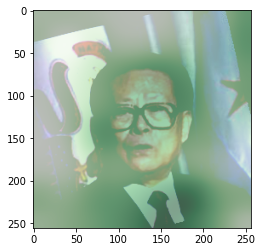

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class = tensor([0.]), Probability = tensor(0.0403)


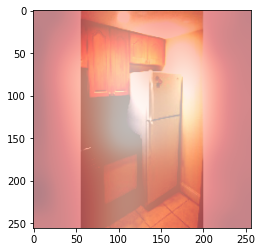

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class = tensor([1.]), Probability = tensor(0.9300)


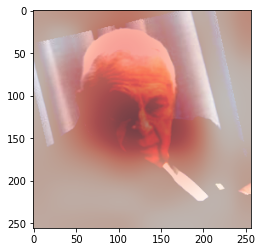

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class = tensor([0.]), Probability = tensor(0.0310)


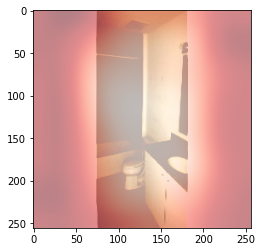

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class = tensor([0.]), Probability = tensor(0.0023)


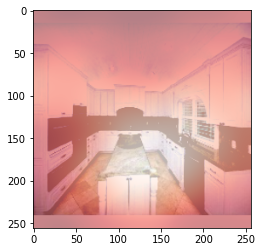

In [105]:
nb_maps = 5
counter = np.random.randint(low=0, high=len(dataset_val), size=nb_maps)
for k in counter:
    show_cam(cam_model, dataset_val, features_stack, preds_stack, image_index=k)


# TEST

In [ ]:
torch.stack((torch.mean(output1, dim=(2,3)), torch.var(output1, dim=(2,3))), dim=2).shape

In [ ]:
with torch.no_grad():
    output1, output2 = resNet50_modelK(dataset_train[4][0].unsqueeze(0))
    output1moy = torch.mean(output1)
    print(output1.shape, output1moy.shape)

torch.Size([1, 512, 28, 28]) torch.Size([1])


moyenne et variance d'un filtre >>> caractériser l'activation de ce filtre (genre snapshot)
image avec une tête >>> activation similaires avec celles de l'entrainement
image noire >>> activation complètement différentes avec celles de l'entrainement
fitter une gaussienne sur les filtres puis trouver la proba d'avoir tel ou tel filtre
>>> si proba trop faible on ignore l'image i.e. c'est un outlayer
En fait on cherche les outlayers
Peut être que si on est trop tot dans le modele il va y avoir trop de bruit et ça sera nul (on ne pourra pas voir si c'est un outlayer ou non)